In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft, rfftfreq
from matplotlib.colors import LogNorm
from itertools import combinations
import sys, os

parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
import telescope_1d
from scipy.stats import norm

<ipython-input-2-990576cca8e4>:43: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(modes, ps_binned[i][:,alpha_idx_binned]/max_val,
/usr/lib/python3/dist-packages/matplotlib/ticker.py:1123: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


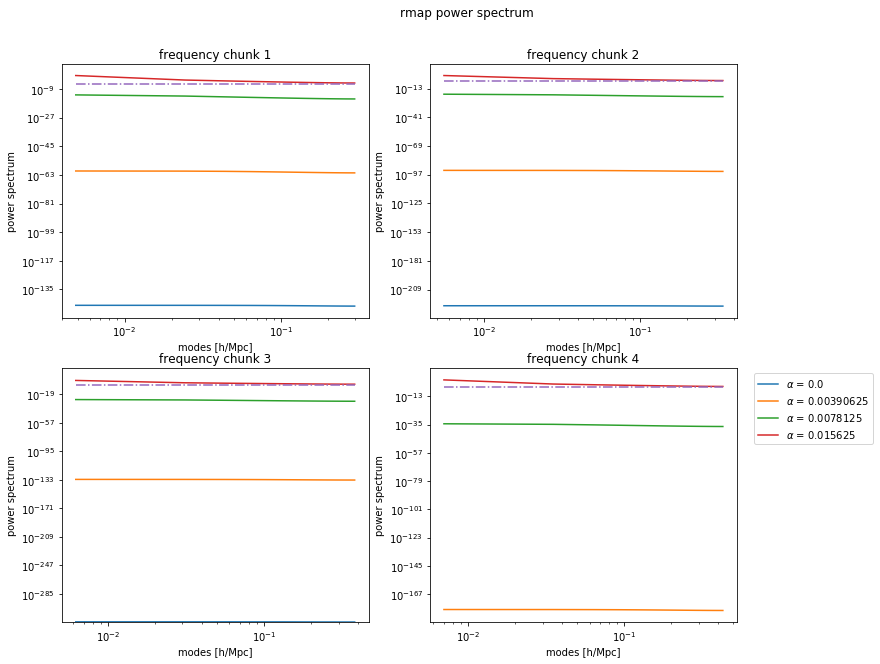

In [2]:
# Sanity check - try ignoring the interferometry
# Initialize telescope array
ndishes = 64
npix = 4096
redundant = True
seed = 1
t = telescope_1d.Telescope1D(Ndishes=ndishes, Npix_fft=npix, redundant=redundant, seed=seed)

# Generate sky
fact = 8192//npix
timag = telescope_1d.Telescope1D(Nfreq=256, Ndishes=ndishes, DDish=6, Npix_fft=8192, Npad=2**8,
                                 minfreq=400, maxfreq=800, redundant=redundant, seed=seed)
image = timag.get_poisson_sky(lam=0.01, seed=seed)
#image = timag.get_uniform_sky(high=2, seed=seed)
#image = timag.get_gaussian_sky(mean=1, sigma_o=0.5, sigma_f=60, seed=seed)
image = np.append(image[:-1].reshape(npix,fact).mean(axis=1),0)

# Instead of observing it, just convolve with beam (frequency independent and dependent)
# Here we are ignoring interferometry, and our beam is constructed as if we have one big dish rather than many dishes
sky = np.zeros((t.Nfreq, t.Npix))
for i,f in enumerate(t.freqs):
    beam = t.beam_no_interferometry(f)
    #sky[i,:] = np.convolve(image, beam**2/np.cos(t.alpha), 'same')
    sky[i,:] = np.convolve(image, beam**2, 'same')

# Shove it into the power spectrum function
Nfreqchunks = 4
(ps_binned, k_modes, alpha_binned) = t.get_rmap_ps(sky, Nfreqchunks=Nfreqchunks, m_alpha=2, m_freq=2, padding=0, window_fn=None, plot=False)

# Plot
alpha_idx_no_source = [t.Npix//2, t.Npix//2+t.Npix//512, t.Npix//2+t.Npix//256, t.Npix//2+t.Npix//128]
fig = plt.figure(figsize=(15,10))
for i in range(Nfreqchunks):
    max_val = np.max(ps_binned[i])
    plt.subplot(2,Nfreqchunks//2,i+1)
    modes = k_modes[i]
    m = t.alpha.shape[0]//alpha_binned.shape[0]
    ax = plt.gca()
    for a in alpha_idx_no_source:
        alpha_idx_binned = a//m
        alpha = t.alpha[a]
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_binned[i][:,alpha_idx_binned]/max_val,
        #plt.loglog(modes, ps_binned[i][:,alpha_idx_binned],
                   linestyle='-', color=color, label=fr'$\alpha$ = {alpha}')
    # Add line at 1e-6
    line = np.array([1e-6 for i in range(len(modes))])
    color = next(ax._get_lines.prop_cycler)['color']
    plt.loglog(modes, line, linestyle='-.', color=color)
    plt.xlabel('modes [h/Mpc]')
    plt.ylabel('power spectrum')
    #plt.ylim(1e-11, 1)
    plt.title('frequency chunk {}'.format(i+1))
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.9, right=0.75)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.suptitle('rmap power spectrum')
plt.show()

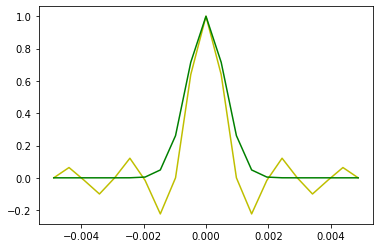

In [3]:
# Check the new beam
image = t.get_point_source_sky(idx=[t.Npix//2])
uvplane = t.observe_image(image)
rmap = t.get_obs_rmap(uvplane, time_error_sigma=0, filter_FG=False)

beam = t.beam_no_interferometry(400)
beam_sq = beam**2

wal = np.where((t.alpha>0-0.005) & (t.alpha<0+0.005))
plt.plot(t.alpha[wal],rmap[0,wal[0]]/np.max(rmap[0,wal[0]]),'y-')
plt.plot(t.alpha[wal],beam_sq[wal]/np.max(beam_sq[wal]),'g-')
plt.show()

(-0.25, 0.25)

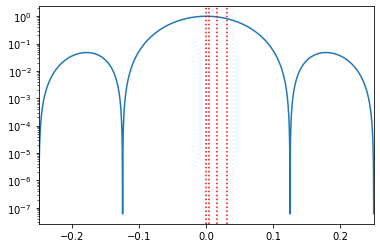

In [4]:
# Plot the alphas we are choosing for the power spectrum slice plots
pbeam = t.primary_beam_1(400)**2
plt.plot(t.alpha,pbeam/pbeam.max())
plt.axvline(x=0, color='r', linestyle=':')
plt.axvline(x=t.alpha[t.Npix//2+t.Npix//512], color='r', linestyle=':')
plt.axvline(x=t.alpha[t.Npix//2+t.Npix//128], color='r', linestyle=':')
plt.axvline(x=t.alpha[t.Npix//2+t.Npix//64], color='r', linestyle=':')
plt.semilogy()
plt.xlim(-0.25,0.25)

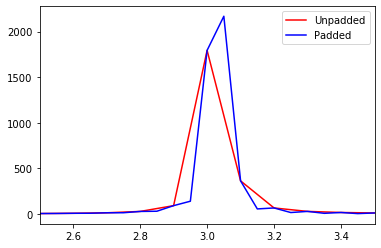

In [5]:
freq_in = 3.0
seconds = 10
sample_rate = 10
# Time in seconds
t = np.linspace(0, seconds, seconds*sample_rate)
# 5 Hz sine wave
sig = np.sin(t*2*np.pi*freq_in)
sig_pad = np.hstack((sig, np.zeros(len(t))))
# Take the power spectra of both
ps = np.abs(rfft(sig)**2)
ps_pad = np.abs(rfft(sig_pad)**2)
freqs = rfftfreq(len(sig), 1./sample_rate)
freqs_padded = rfftfreq(len(sig_pad), 1./sample_rate)
# Plot to make sure they look the same:
plt.plot(freqs, ps, 'r', label="Unpadded")
plt.plot(freqs_padded, ps_pad, 'b', label="Padded")
plt.xlim(2.5, 3.5)
plt.legend()